In [1]:
import numpy as np
import pandas as pd
import os
from typing import List, Optional
import ast
import seaborn as sns
import matplotlib.pyplot as plt


from results_processing import get_groups, get_dataset, flatten_results, get_top_models, plot_per_model_metrics, clean_model_names, pivot_per_dataset, plot_per_datasets

# 1. Data post-processing

In [2]:
lcn_data = clean_model_names(pd.read_csv('LcnTotalResults.csv'))
mlp_data = clean_model_names(pd.read_csv('MlpPartialResults.csv'))
multi_data = clean_model_names(pd.read_csv('MultiModalResults.csv'))

data_groups = get_groups()

In [3]:
regression_cat_groups = data_groups['opml_reg_numcat_group']
regression_num_groups = data_groups['opml_reg_purnum_group']
classification_cat_groups = data_groups['opml_class_numcat_group']
classification_num_groups = data_groups['opml_class_purnum_group']


regression_groups = regression_cat_groups + regression_num_groups
classification_groups = classification_cat_groups + classification_num_groups

In [21]:
print(f'Total number of regression datasets: {len(regression_groups)}')
print(f'Total number of classificaitondatasets: {len(classification_groups)}')
print(f'Total number of datasets: {len(regression_groups) + len(classification_groups)}')

Total number of regression datasets: 36
Total number of classificaitondatasets: 23
Total number of datasets: 59


In [5]:
lcn_reg = get_dataset(lcn_data, regression_groups)
mlp_reg = get_dataset(mlp_data, regression_groups)
multi_reg = get_dataset(multi_data, regression_groups)

lcn_cls = get_dataset(lcn_data, classification_groups)
mlp_cls = get_dataset(mlp_data, classification_groups)
multi_cls = get_dataset(multi_data, classification_groups)

reg_datasets = pd.concat([lcn_reg, mlp_reg, multi_reg], ignore_index=True)
cls_datasets = pd.concat([lcn_cls, mlp_cls, multi_cls], ignore_index=True)

In [6]:
reg_results = flatten_results(reg_datasets, ['metrics'])
cls_results = flatten_results(cls_datasets, ['metrics'])

In [7]:
print(reg_results.columns)
print(cls_results.columns)

Index(['dataset', 'hyperparameters', 'model', 'train_loss', 'epoch',
       'val_loss', 'test_loss', 'epoch_time', 'train_metrics.RMSE',
       'train_metrics.r2_score', 'train_metrics.se_quant', 'val_metrics.RMSE',
       'val_metrics.r2_score', 'val_metrics.se_quant', 'test_metrics.RMSE',
       'test_metrics.r2_score', 'test_metrics.se_quant',
       'validate_metrics.r2_score', 'validate_metrics.RMSE',
       'validate_metrics.se_quant'],
      dtype='object')
Index(['dataset', 'hyperparameters', 'model', 'train_loss', 'val_loss',
       'test_loss', 'epoch', 'epoch_time', 'train_metrics.accuracy_score',
       'train_metrics.roc_auc_score', 'train_metrics.confusion_matrix',
       'val_metrics.accuracy_score', 'val_metrics.roc_auc_score',
       'val_metrics.confusion_matrix', 'test_metrics.accuracy_score',
       'test_metrics.roc_auc_score', 'test_metrics.confusion_matrix',
       'validate_metrics.accuracy_score', 'validate_metrics.confusion_matrix',
       'validate_metrics.ro

# 2. Analyzing results

In [8]:
top_acc_score = get_top_models(cls_results, 'val_metrics.accuracy_score')

In [9]:
top_acc_score

,dataset,hyperparameters,model,train_loss,val_loss,test_loss,epoch,epoch_time,train_metrics.accuracy_score,train_metrics.roc_auc_score,train_metrics.confusion_matrix,val_metrics.accuracy_score,val_metrics.roc_auc_score,val_metrics.confusion_matrix,test_metrics.accuracy_score,test_metrics.roc_auc_score,test_metrics.confusion_matrix,validate_metrics.accuracy_score,validate_metrics.confusion_matrix,validate_metrics.roc_auc_score
4958,337-361062,"{'depth': 11, 'seed': 42, 'regularize': None, ...",Mlp_relu,0.000646,461.861298,519.545288,60.0,243.870896,0.985317,0.998845,"[[2478, 42], [32, 2488]]",0.955159,0.990620,"[[1209, 51], [62, 1198]]",0.945282,0.988719,"[[1210, 51], [87, 1174]]",NaN,NaN,NaN
304,337-361068,"{'depth': 12, 'seed': 42, 'drop_type': 'isDrop...",LLN,0.001968,995.223022,917.247437,30.0,184.295108,0.951900,0.989550,"[[4716, 284], [197, 4803]]",0.933200,0.976689,"[[2313, 187], [147, 2353]]",0.930200,0.979867,"[[2298, 202], [147, 2353]]",NaN,NaN,NaN
3817,337-361068,"{'depth': 3, 'seed': 42, 'regularize': 'bn', '...",Mlp_relu,0.001715,959.144165,907.396606,60.0,451.511037,0.970900,0.995847,"[[4819, 181], [110, 4890]]",0.929400,0.976728,"[[2303, 197], [156, 2344]]",0.928600,0.979506,"[[2296, 204], [153, 2347]]",NaN,NaN,NaN
3826,337-361068,"{'depth': 5, 'seed': 42, 'regularize': 'bn', '...",Mlp_sigm,0.001554,967.122498,914.450195,60.0,460.041099,0.974900,0.995952,"[[4829, 171], [80, 4920]]",0.929000,0.976664,"[[2302, 198], [157, 2343]]",0.929400,0.979342,"[[2295, 205], [148, 2352]]",NaN,NaN,NaN
256,337-361068,"{'depth': 9, 'seed': 42, 'drop_type': 'isDropC...",LCN,0.005546,1623.985107,1615.484985,30.0,211.312106,0.890200,0.931102,"[[4457, 543], [555, 4445]]",0.890800,0.936683,"[[2219, 281], [265, 2235]]",0.890000,0.938082,"[[2222, 278], [272, 2228]]",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8730,334-361283,"{'max_depth': 3, 'n_estimators': 117, 'min_chi...",XGBoost,NaN,NaN,NaN,NaN,2.748338,0.757384,0.840671,"[[2658, 660], [950, 2368]]",NaN,NaN,NaN,0.699819,0.758832,"[[1245, 414], [582, 1077]]",0.714587,"[[1257, 402], [545, 1114]]",0.787109
8731,334-361283,"{'loss': 'exponential', 'learning_rate': 0.003...",SK_gradBoost,NaN,NaN,NaN,NaN,6.914992,0.711875,0.781586,"[[2792, 526], [1386, 1932]]",NaN,NaN,NaN,0.689873,0.750897,"[[1346, 313], [716, 943]]",0.714587,"[[1400, 259], [688, 971]]",0.788055
8732,334-361283,"{'max_depth': None, 'criterion': 'gini', 'max_...",SK_decisionTree,NaN,NaN,NaN,NaN,0.093270,0.935202,0.991024,"[[3231, 87], [343, 2975]]",NaN,NaN,NaN,0.608800,0.631155,"[[1094, 565], [733, 926]]",0.619952,"[[1090, 569], [692, 967]]",0.644874
8733,334-361283,"{'n_estimators': 28, 'learning_rate': 0.238019...",LGBM,NaN,NaN,NaN,NaN,0.195555,0.755576,0.838171,"[[2740, 578], [1044, 2274]]",NaN,NaN,NaN,0.710066,0.764484,"[[1297, 362], [600, 1059]]",0.718807,"[[1317, 342], [591, 1068]]",0.793008


In [10]:
def plot_per_model_metrics(df, metric, jitter=False):
    # Create the plot
    sns.stripplot(data=df, x='model', y=metric, hue='model', jitter=jitter, dodge=True)

    # Add labels and title
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.title(f'{metric} by Model')

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Set the Y-axis limits
    plt.ylim([0, 1])

    # Add a legend
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show the plot
    plt.show()

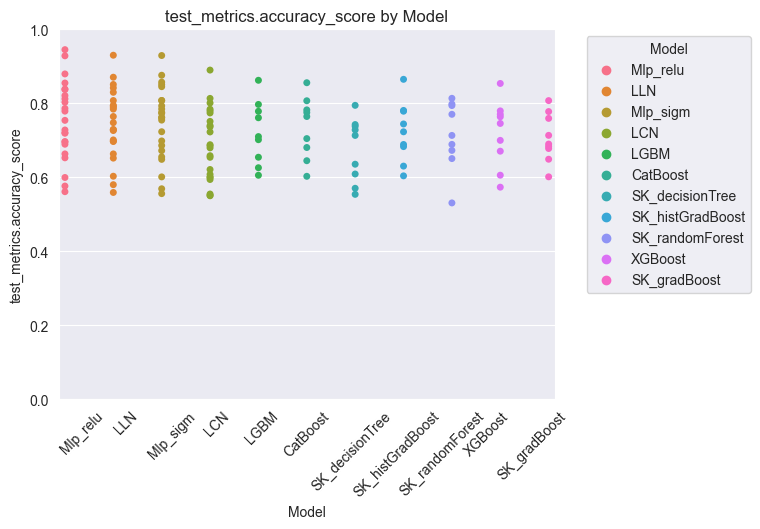

In [11]:
plot_per_model_metrics(top_acc_score, 'test_metrics.accuracy_score')

In [14]:
def pivot_per_dataset(df: pd.DataFrame, results_column: str) -> pd.DataFrame:
    pivot_df = pd.pivot_table(df,
                              values=results_column,
                              index='model',
                              columns='dataset',
                              aggfunc=list, # Since you have multiple 'top' values, aggregate them into a list
                              fill_value=None)

    # Flatten the multi-index (if any) and reset the index for the DataFrame
    pivot_df.columns = [col if not isinstance(col, tuple) else '_'.join(col) for col in pivot_df.columns]
    pivot_df.reset_index(inplace=True)

    return pivot_df

In [15]:
top_acc_per_dataset = pivot_per_dataset(top_acc_score, 'test_metrics.accuracy_score')

In [20]:
def plot_per_datasets(df: pd.DataFrame, datasets: List[str]) -> None:
    # Melt the DataFrame for seaborn
    melted_df = df.melt(id_vars='model', value_vars=datasets)

    # Create the plot
    plt.figure(figsize=(12, 8))
    sns.stripplot(x='model', y='value', hue='variable', data=melted_df, jitter=True, dodge=True)

    plt.xlabel('Model')
    plt.ylabel('Metric Value')
    plt.legend(title='Dataset')

    # Scale Y-axis
    plt.ylim(0, 1)

    # Rotate X-axis labels for better visibility
    plt.xticks(rotation=90)

    plt.show()

24

In [22]:
top_acc_per_dataset.columns

Index(['model', '334-361110', '334-361111', '334-361113', '334-361282',
       '334-361283', '334-361285', '334-361286', '337-361055', '337-361060',
       '337-361061', '337-361062', '337-361063', '337-361065', '337-361066',
       '337-361068', '337-361069', '337-361070', '337-361273', '337-361274',
       '337-361275', '337-361276', '337-361277', '337-361278'],
      dtype='object')